In [1]:
%pip install -r ../requirements.txt
!python -V

You should consider upgrading via the '/home/david.gomez/WEDISTRICT/notebooks/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Python 3.8.0


# Imports Section

In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --------------------------

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_parquet('../data/fhv_tripdata_2021-01.parquet')

# Calculation of the duration
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# Short version (for testing) - comment to carry out with the whole dataset
# df = df[1:500]
df.head(10)

# categorical = ['PULocationID', 'DOLocationID']
# numerical = ['trip_distance']

# df[categorical] = df[categorical].astype(str)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000
6,B00037,2021-01-01 00:18:12,2021-01-01 00:30:04,NaN,91.0,None,B00037,11.866667
7,B00037,2021-01-01 00:36:15,2021-01-01 00:45:08,NaN,39.0,None,B00037,8.883333
8,B00037,2021-01-01 00:55:04,2021-01-01 01:13:02,NaN,37.0,None,B00037,17.966667
9,B00037,2021-01-01 00:48:40,2021-01-01 01:12:02,NaN,39.0,None,B00037,23.366667


In [4]:
# Number of records 
original_dataset_size = df.shape
print (f'(Original dataset shape: Rows ({original_dataset_size[0]}) x Columns ({original_dataset_size[1]})')

(Original dataset shape: Rows (1154112) x Columns (8)


In [5]:
# Average trip duration
avg_duration = df.duration.mean()
print (f'Average duration (min) = {avg_duration}')

# Filter one hour trips
df = df[(df.duration >= 1) & (df.duration <= 60)]
print (f'Records dropped (<1 min or > 60 min) ) {original_dataset_size[0] - df.shape[0]}')

Average duration (min) = 19.167224093791006
Records dropped (<1 min or > 60 min) ) 44286


In [6]:
# Missing values calculation
df['PUlocationID'] = df['PUlocationID'].replace(np.NaN, -1)
df['DOlocationID'] = df['DOlocationID'].replace(np.NaN, -1)

# df_missing = df[(df['PUlocationID'] == -1.0) | (df['DOlocationID'] == -1.0)]
df_missing = df[df['PUlocationID'] == -1.0]
df_filter = df[(df['PUlocationID'] != -1.0) & (df['DOlocationID'] != -1.0)]

fraction = len(df_missing) / len(df)

print (f'Original {df.shape[0]} - missing {df_missing.shape[0]} ({len(df_missing) / len(df)}%) - Ready-to-go {df_filter.shape[0]} ({len(df_filter) / len (df)}%)')


Original 1109826 - missing 927008 (0.8352732770722617%) - Ready-to-go 171670 (0.15468190509142873%)


In [11]:
# One-hot encoding
categorical = ['PUlocationID', 'DOlocationID']
# numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)  

target = 'duration'
y_train = df[target].values

array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
       19.43333333, 36.        ])

In [12]:
# Linear regression model (default params)
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107206375

In [18]:
# Validation dataset (load)
df_val = pd.read_parquet('../data/fhv_tripdata_2021-02.parquet')

In [17]:
df_val = df[(df.duration >= 1) & (df.duration <= 60)]

df_val[categorical] = df_val[categorical].astype(str)
val_dicts = df[categorical].to_dict(orient='records')

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00013,2021-02-01 00:01:00,2021-02-01 01:33:00,NaN,NaN,None,B00014
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,None,B00021
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,None,B00021
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,None,B00021
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,NaN,225.0,None,B00037


In [16]:
dv = DictVectorizer()
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

AttributeError: 'DictVectorizer' object has no attribute 'feature_names_'

/home/david.gomez/WEDISTRICT/notebooks/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/david.gomez/WEDISTRICT/notebooks/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


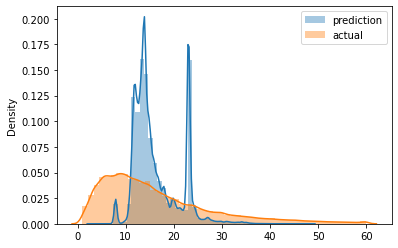

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479513631630414

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728